In [ ]:
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#collecting the dataset from drive and split into training and validation set

In [ ]:
pip install split-folders

In [ ]:
url='https://drive.google.com/file/d/12cy6nEEDAfL6isqnTlJIRy8NZLPtIMpE/view?usp=sharing'
data=tf.keras.utils.get_file('archive.zip',extract=True,
                            origin=url)
path=os.path.join(os.path.dirname(data),'plantvillage dataset')


   8192/Unknown - 0s 0us/step

In [ ]:
!unzip '/content/gdrive/MyDrive/Capstone_project/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to ratio, i.e, (.8, .2).
splitfolders.ratio('/content/plantvillage dataset/segmented', output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]
Copying files: 334 files [00:00, 3338.48 files/s]
Copying files: 895 files [00:00, 3798.84 files/s]
Copying files: 1498 files [00:00, 4272.32 files/s]
Copying files: 1996 files [00:00, 4461.47 files/s]
Copying files: 2571 files [00:00, 4782.86 files/s]
Copying files: 3035 files [00:00, 4737.41 files/s]
Copying files: 3673 files [00:00, 5133.25 files/s]
Copying files: 4186 files [00:00, 5130.91 files/s]
Copying files: 4822 files [00:00, 5445.18 files/s]
Copying files: 5370 files [00:01, 4878.70 files/s]
Copying files: 6006 files [00:01, 5244.26 files/s]
Copying files: 6620 files [00:01, 5482.36 files/s]
Copying files: 7243 files [00:01, 5686.09 files/s]
Copying files: 7824 files [00:01, 5314.70 files/s]
Copying files: 8380 files [00:01, 5385.63 files/s]
Copying files: 8993 files [00:01, 5588.82 files/s]
Copying files: 9561 files [00:01, 5006.71 files/s]
Copying files: 10080 files [00:01, 4206.50 files/s]
Copying files: 10535 files [00:02, 3419.

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./output/train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 43430 images belonging to 38 classes.


In [ ]:
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=train_datagen.flow_from_directory('./output/val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 10876 images belonging to 38 classes.


In [ ]:
# TRansfer Learning
def MobileNetV2_Model():
  base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                            include_top=False,weights='imagenet')
  base_model.trainable=False # freeze model
  x=base_model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  x=Dense(1024,activation='relu')(x) #dense layer 2
  x=Dense(512,activation='relu')(x) #dense layer 3
  preds=Dense(38,activation='softmax')(x)
  return base_model,preds


In [ ]:
def train_model(base_model,preds):
  model=Model(inputs=base_model.input,outputs=preds)
  for layer in model.layers[:20]:
    layer.trainable=False
  for layer in model.layers[20:]:
    layer.trainable=True

  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
  step_size_train=train_generator.n//train_generator.batch_size
  history=model.fit_generator(generator=train_generator,
                   validation_data =val_generator,
                  steps_per_epoch=step_size_train,
                   
                   epochs=10)
  return model,history


In [ ]:
base_model,preds=MobileNetV2_Model()

MobileNetV2,history=train_model(base_model,preds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1357/1357 [==============================] - 155s 111ms/step - loss: 0.9089 - accuracy: 0.7525 - val_loss: 11.5000 - val_accuracy: 0.1537
Epoch 2/10
1357/1357 [==============================] - 149s 110ms/step - loss: 0.2524 - accuracy: 0.9298 - val_loss: 10.7890 - val_accuracy: 0.1288
Epoch 3/10
1357/1357 [==============================] - 148s 109ms/step - loss: 0.2300 - accuracy: 0.9373 - val_loss: 1.3610 - val_accuracy: 0.6912
Epoch 4/10
1357/1357 [==============================] - 148s 109ms/step - loss: 0.1728 - accuracy: 0.9530 - val_loss: 3.0438 - val_accuracy: 0.5725
Epoch 5/10
1357/1357 [==============================] - 148s 109ms/step - loss: 0.1458 - accuracy: 0.9608 - val_loss: 1.5962 - val_accuracy: 0.6999
Epoch 6/10
1357/1357 [==============================] - 147s 109ms/step - loss: 0.1384 - accuracy: 0.9636 - val_loss: 1.4921 - val_accuracy: 0.7787
Epoch 7/10
1357/1357 [==============================] - 148s 109ms/step - loss: 0.1136 - accuracy: 0.9693 - va

In [ ]:
MobileNetV2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

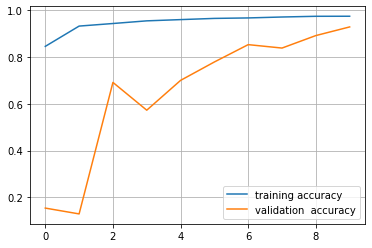

In [ ]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation  accuracy')
plt.grid(True)
plt.legend()

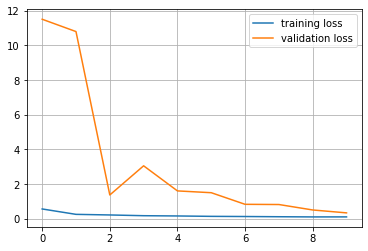

In [ ]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.legend()

In [ ]:
MobileNetV2.save("/content/gdrive/MyDrive/Capstone_project/MobileNetV2.h5")

In [ ]:
from keras.models import load_model 
model2=load_model('MobileNetV2')
model2.summary()

In [ ]:
from keras.models import load_model 
model2=load_model('/content/gdrive/MyDrive/Capstone_project/MobileNetV2.h5')


#Training the VGG16 pretrained model by our plant village dataset

In [ ]:
def VGG16_model():
  base_model=tf.keras.applications.VGG16(input_shape=(224,224,3),
                            include_top=False,weights='imagenet')
  base_model.trainable=False # freeze model
  x=base_model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
  x=Dense(1024,activation='relu')(x) #dense layer 2
  x=Dense(512,activation='relu')(x) #dense layer 3
  preds=Dense(38,activation='softmax')(x)
  return base_model,preds


In [ ]:

base_model_1,preds=VGG16_model()

VGG16,history=train_model(base_model_1,preds)

58892288/58889256 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1357/1357 [==============================] - 154s 111ms/step - loss: 1.1402 - accuracy: 0.6649 - val_loss: 0.3273 - val_accuracy: 0.8898
Epoch 2/10
1357/1357 [==============================] - 142s 105ms/step - loss: 0.3337 - accuracy: 0.8869 - val_loss: 0.2809 - val_accuracy: 0.9061
Epoch 3/10
1357/1357 [==============================] - 142s 104ms/step - loss: 0.2695 - accuracy: 0.9089 - val_loss: 0.2953 - val_accuracy: 0.9013
Epoch 4/10
1357/1357 [==============================] - 138s 101ms/step - loss: 0.2178 - accuracy: 0.9246 - val_loss: 0.2607 - val_accuracy: 0.9177
Epoch 5/10
1357/1357 [==============================] - 136s 100ms/step - loss: 0.1964 - accuracy: 0.9319 - val_loss: 0.2406 - val_accuracy: 0.9223
Epoch 6/10
1357/1357 [==============================] - 135s 100ms/step - loss: 0.1783 - accuracy: 0.9390 - val_loss: 0.1684 - val_accuracy: 0.9461
Epoch 7/10
1357/1357 [==============================] - 134s 99ms/step - loss: 0.1522 - accuracy: 0.9463 - val_l

In [ ]:
VGG16.save('/content/gdrive/MyDrive/Capstone_project/VGG16.h5')

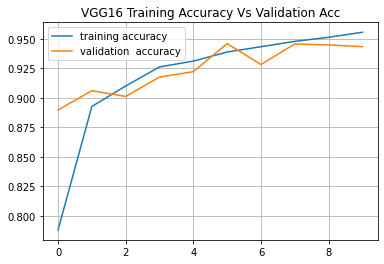

In [ ]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation  accuracy')
plt.grid(True)
plt.title("VGG16 Training Accuracy Vs Validation Acc")
plt.legend()

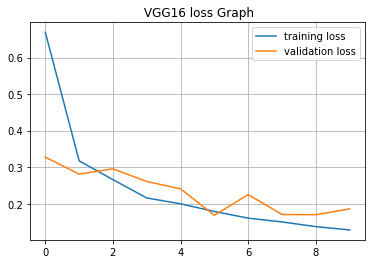

In [ ]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.title(" VGG16 loss Graph")
plt.legend()